## Kaggle – DataTops®
Tu profe ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a tu profe a mejorar ese modelo?

## Métrica: 
El error cuadrático medio (RMSE, por sus siglas en inglés) es una medida de la desviación estándar de los residuos (errores de predicción). Los residuos representan la diferencia entre los valores observados y los valores predichos por el modelo. El RMSE indica qué tan dispersos están estos errores: cuanto menor es el RMSE, más cercanas están las predicciones a los valores reales. En otras palabras, el RMSE mide qué tan bien se ajusta la línea de regresión a los datos.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## 1. Librerías

In [256]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request

from PIL import Image
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR

# Modelos
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from bootcampviztools import plot_grouped_histograms


## 1. Funciones

In [257]:
def categorizar_company(company):
    tipoCOM = 0
    if company in ["Mediacom","Chuwi","Vero"]:
        tipoCOM = 1
    elif company in ["Lenovo","Asus","Acer","Fujitsu"]:
        tipoCOM = 2
    elif company in ["HP","Dell"]:
        tipoCOM = 3
    elif company in ["Apple","MSI","Microsoft","Samsung","Xiaomi"]:
        tipoCOM = 4
    elif company in ["Toshiba","Googl","Razer"]:
        tipoCOM = 5
    return tipoCOM

In [258]:
def tarjeta_gtx(card):
    tipoGTX = 0
    if "GTX" in card:
        tipoGTX = 1
    return tipoGTX

In [259]:
def capacidad_almacenamiento(disks):
    capacidad = 0
    tipoS = 0
    tipoH = 0
    tipoF = 0
    variedad = disks.split()
    for elem in variedad:
        if "GB" in elem:
            disco = elem.replace("GB","")
            disco = float(disco)
            capacidad = capacidad + (disco/1000)
        elif "TB" in elem:
            disco = elem.replace("TB","")
            disco = float(disco)
            capacidad = capacidad + disco
        elif "SSD" in elem:
            tipoS = 1
        elif "Flash" in elem:
            tipoF = 1
        else:
            tipoH = 1
        
    return([round(capacidad, 3),tipoS, tipoH, tipoF])


## 2. Datos

In [260]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv")

### 2.1 Exploración de los datos

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   Product           912 non-null    object 
 3   TypeName          912 non-null    object 
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    object 
 6   Cpu               912 non-null    object 
 7   Ram               912 non-null    object 
 8   Memory            912 non-null    object 
 9   Gpu               912 non-null    object 
 10  OpSys             912 non-null    object 
 11  Weight            912 non-null    object 
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), object(10)
memory usage: 92.8+ KB


In [262]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
0,755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
1,618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
2,909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
3,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
4,286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [263]:
df.tail()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
907,28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
908,1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
909,78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
910,23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00
911,229,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.42kg,2456.34


In [264]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
laptop_ID,912.0,650.312500,382.727748,2.0,324.75,636.5,982.2500,1320.0
Inches,912.0,14.981579,1.436719,10.1,14.00,15.6,15.6000,18.4
Price_in_euros,912.0,1111.724090,687.959172,174.0,589.00,978.0,1483.9425,6099.0


In [344]:
df.sort_values(by = "Price_in_euros").head(40)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
603,1233,Acer,C740-C9QX (3205U/2GB/32GB/Chrome,Netbook,11.6,1366x768,Intel Celeron Dual Core 3205U 1.5GHz,2GB,32GB SSD,Intel HD Graphics,Chrome OS,1.3kg,174.00
173,21,Asus,Vivobook E200HA,Netbook,11.6,1366x768,Intel Atom x5-Z8350 1.44GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Windows 10,0.98kg,191.90
424,32,Asus,E402WA-GA010T (E2-6110/2GB/32GB/W10),Notebook,14.0,1366x768,AMD E-Series E2-6110 1.5GHz,2GB,32GB Flash Storage,AMD Radeon R2,Windows 10,1.65kg,199.00
305,295,Acer,Chromebook C910-C2ST,Notebook,15.6,1366x768,Intel Celeron Dual Core 3205U 1.5GHz,2GB,16GB SSD,Intel HD Graphics,Chrome OS,2.19kg,199.00
366,1300,HP,Stream 11-Y000na,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.17kg,209.00
331,1117,Acer,Chromebook 15,Notebook,15.6,1366x768,Intel Celeron Dual Core 3205U 1.5GHz,4GB,16GB SSD,Intel HD Graphics,Chrome OS,2.20kg,209.00
667,1286,HP,Stream 11-Y000na,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.17kg,209.00
325,1055,Vero,V142 (X5-Z8350/2GB/32GB/W10),Notebook,14.0,1366x768,Intel Atom X5-Z8350 1.44GHz,2GB,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.45kg,210.80
613,562,Asus,A541NA-GO342 (N3350/4GB/500GB/Linux),Notebook,15.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,500GB HDD,Intel HD Graphics 500,Linux,2kg,224.00
632,1304,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00


In [266]:
df.sort_values(by = "Price_in_euros").tail(40)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
348,321,HP,Spectre x360,2 in 1 Convertible,13.3,IPS Panel 4K Ultra HD / Touchscreen 3840x2160,Intel Core i7 8550U 1.8GHz,16GB,1TB SSD,Intel UHD Graphics 620,Windows 10,1.29kg,2449.00
579,1227,Asus,Rog Strix,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.2kg,2449.00
116,650,Lenovo,ThinkPad X1,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.14kg,2450.00
911,229,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.42kg,2456.34
709,316,Dell,XPS 13,Ultrabook,13.3,IPS Panel 4K Ultra HD / Touchscreen 3840x2160,Intel Core i7 8550U 1.8GHz,16GB,1TB SSD,Intel UHD Graphics 620,Windows 10,1.21kg,2499.00
624,263,MSI,GT73EVR 7RE,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.14kg,2499.00
604,831,Lenovo,Thinkpad X1,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.13kg,2499.00
354,278,Lenovo,ThinkPad X1,2 in 1 Convertible,14.0,Touchscreen 2560x1440,Intel Core i7 6600U 2.6GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.36kg,2499.00
365,827,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.36kg,2505.02
485,395,Lenovo,ThinkPad X1,2 in 1 Convertible,14.0,Touchscreen 2560x1440,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.42kg,2509.00


### 2.3 Definir X e y

In [267]:
X = df.drop(['Price_in_euros'], axis=1)
y = df['Price_in_euros'].copy()
X.shape

(912, 12)

In [268]:
X.shape

(912, 12)

In [269]:
y.shape

(912,)

### 2.4 Dividir X_train, X_test, y_train, y_test

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [271]:
X_train

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
25,1118,HP,ZBook 17,Workstation,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8GB,1TB HDD,AMD FirePro W6150M,Windows 7,3.0kg
84,153,Dell,Inspiron 5577,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1050,Windows 10,2.56kg
10,275,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.9GHz,8GB,512GB SSD,Intel Iris Graphics 550,macOS,1.37kg
342,1100,HP,EliteBook 840,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,500GB HDD,Intel HD Graphics 520,Windows 7,1.54kg
890,131,Dell,Inspiron 5770,Notebook,17.3,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,256GB SSD + 2TB HDD,AMD Radeon 530,Windows 10,2.8kg
...,...,...,...,...,...,...,...,...,...,...,...,...
106,578,HP,14-am079na (N3710/8GB/2TB/W10),Notebook,14.0,1366x768,Intel Pentium Quad Core N3710 1.6GHz,8GB,2TB HDD,Intel HD Graphics 405,Windows 10,1.94kg
270,996,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,Full HD 1920x1080,AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg
860,770,Dell,Latitude 7280,Ultrabook,12.5,Full HD 1920x1080,Intel Core i7 7600U 2.8GHz,16GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.18kg
435,407,Lenovo,IdeaPad 320-15IAP,Notebook,15.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,1TB HDD,Intel HD Graphics 500,Windows 10,2.2kg


In [272]:
y_train

25     2899.00
84     1249.26
10     1958.90
342    1030.99
890    1396.00
        ...   
106     389.00
270     549.00
860    1859.00
435     306.00
102    1943.00
Name: Price_in_euros, Length: 729, dtype: float64

## 3. Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [273]:
target = "Price_in_euros"
features = X_train.columns.tolist()
train_set = pd.concat([X_train, y_train], axis = 1)
test_set = pd.concat([X_test, y_test], axis = 1)

In [274]:
lista_cardinalidad = []
headers = ["Columna", "Valores","Cardinalidad"]

for col in train_set:
    valores_unicos = train_set[col].nunique()
    cardinalidad = round(valores_unicos/len(train_set[col]),2)
    lista_cardinalidad.append([col,valores_unicos,cardinalidad])

# Print table headers
print("Index".ljust(10), end = "")
for col in headers:
    print(col.ljust(20), end="")
print()

# Print table rows
for i, row in enumerate(lista_cardinalidad, start = 1):
    print(str(i).ljust(10), end = "")                      
    for col in row:
        print(str(col).ljust(20), end = "")
    print()

Index     Columna             Valores             Cardinalidad        
1         laptop_ID           729                 1.0                 
2         Company             17                  0.02                
3         Product             408                 0.56                
4         TypeName            6                   0.01                
5         Inches              15                  0.02                
6         ScreenResolution    33                  0.05                
7         Cpu                 93                  0.13                
8         Ram                 8                   0.01                
9         Memory              33                  0.05                
10        Gpu                 84                  0.12                
11        OpSys               9                   0.01                
12        Weight              148                 0.2                 
13        Price_in_euros      504                 0.69                


In [275]:
#------------------------------------CAMBIO 0--------------------------------------------
#------------------------------------CAMBIO 0--------------------------------------------
#------------------------------------CAMBIO 0--------------------------------------------

features_sel = []

# Train
train_set.set_index("laptop_ID", inplace = True)

# Test
test_set.set_index("laptop_ID", inplace = True)


In [276]:
print(train_set.Company.nunique())
train_set.Company.value_counts()

17


Company
Lenovo       162
Dell         158
HP           155
Asus         101
Acer          55
Toshiba       31
MSI           30
Apple         13
Mediacom       4
Razer          4
Xiaomi         3
Samsung        3
Microsoft      3
Google         2
Fujitsu        2
Vero           2
Chuwi          1
Name: count, dtype: int64

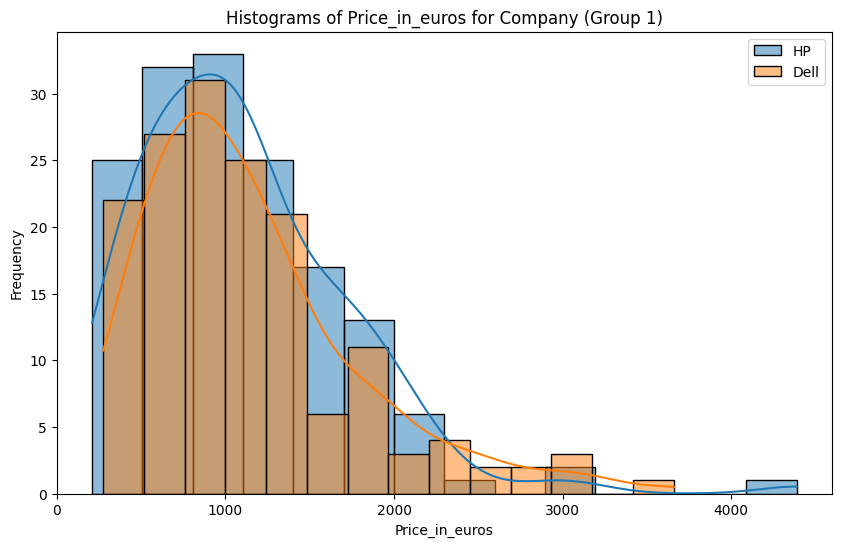

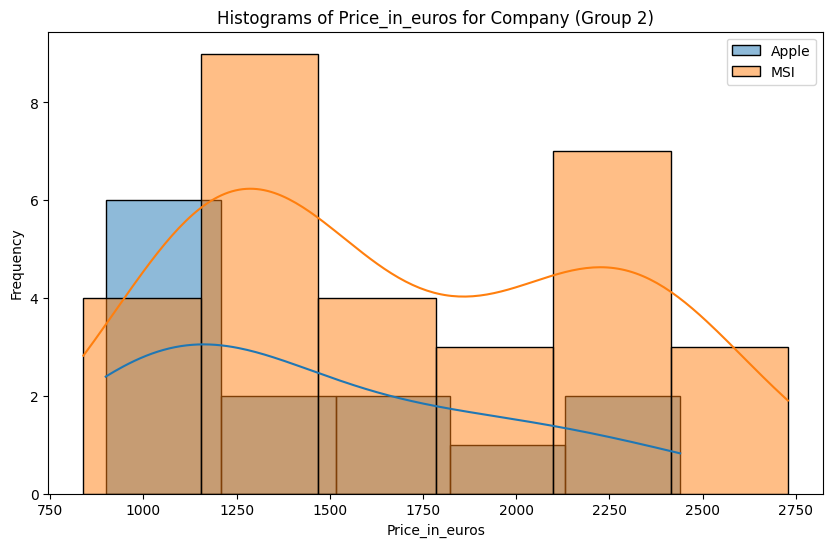

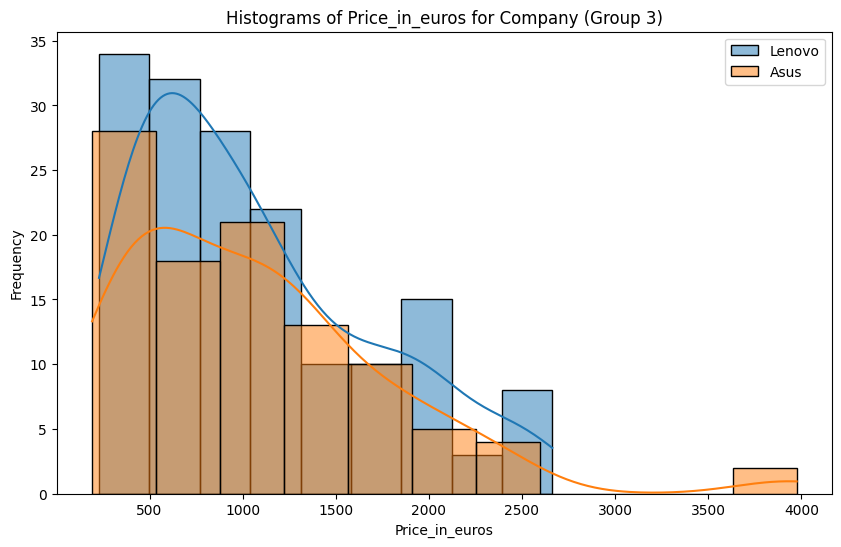

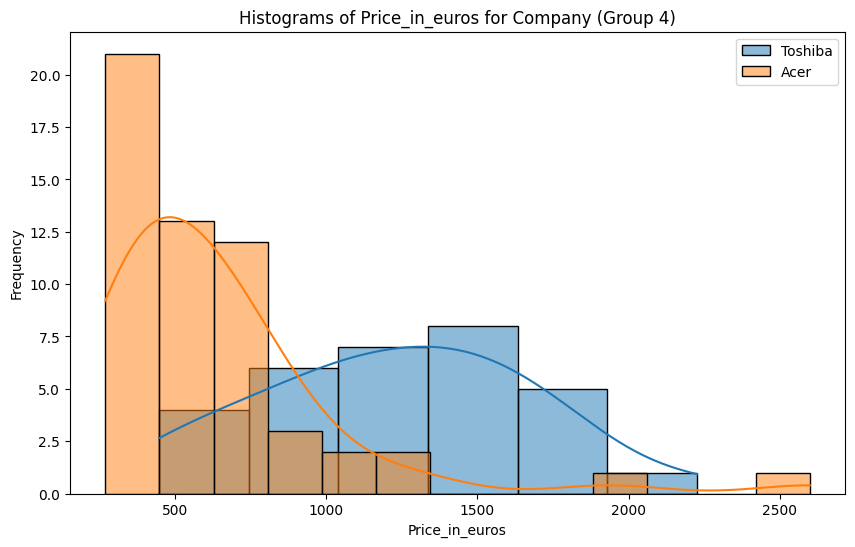

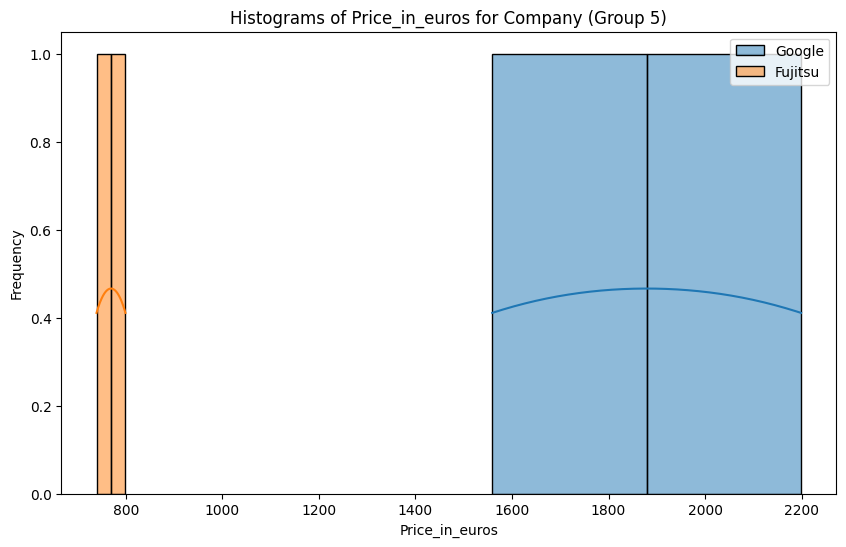

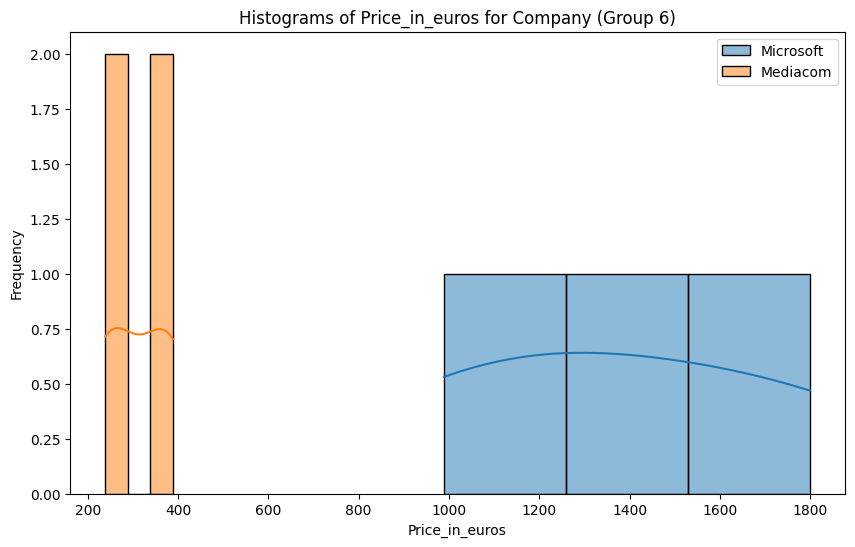

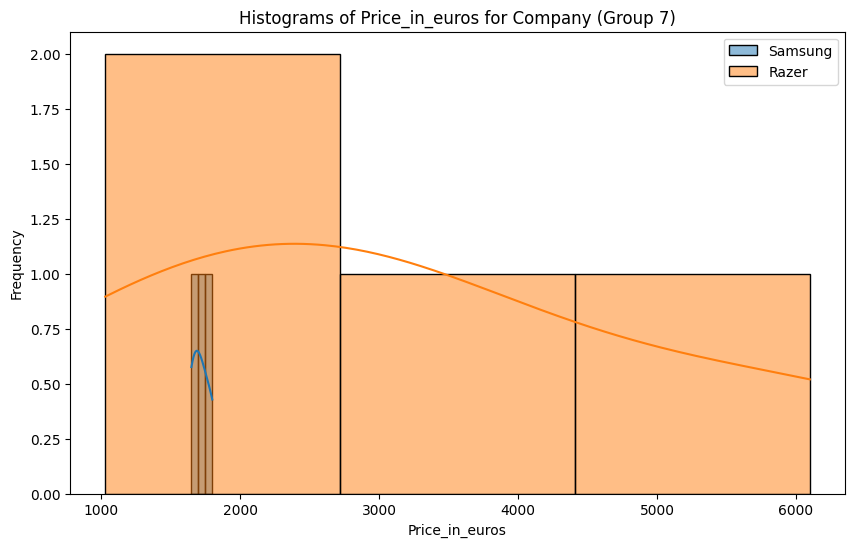

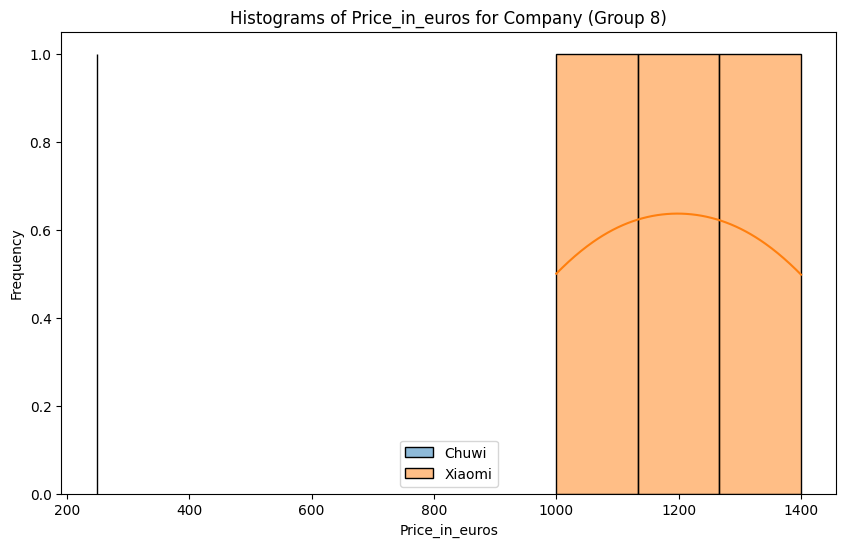

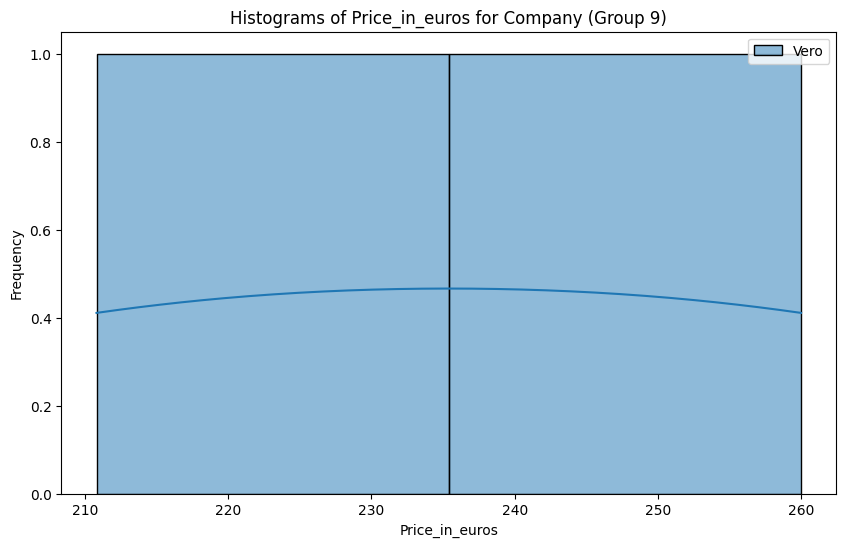

In [277]:
plot_grouped_histograms(train_set, "Company","Price_in_euros",group_size= 2)

In [278]:
#------------------------------------CAMBIO COMPANY--------------------------------------------
#------------------------------------CAMBIO COMPANY--------------------------------------------
#------------------------------------CAMBIO COMPANY--------------------------------------------

# Train
train_set["Company_cat"] = 0
colcom = train_set.columns.get_loc("Company_cat")
ncol = train_set.columns.get_loc("Company")

for index in range(len(train_set)):
    train_set.iloc[index,colcom] = categorizar_company(train_set.iloc[index,ncol])

# Test
test_set["Company_cat"] = 0
colcom = test_set.columns.get_loc("Company_cat")
ncol = test_set.columns.get_loc("Company")

for index in range(len(test_set)):
    test_set.iloc[index,colcom] = categorizar_company(test_set.iloc[index,ncol])


In [279]:
features_sel.append("Company_cat")

In [280]:
print(train_set.TypeName.nunique())
train_set.TypeName.value_counts()

6


TypeName
Notebook              412
Gaming                113
Ultrabook             113
2 in 1 Convertible     62
Netbook                16
Workstation            13
Name: count, dtype: int64

In [281]:
features_sel.append("TypeName")

In [282]:
print(train_set.Inches.nunique())
train_set.Inches.value_counts()

15


Inches
15.6    362
14.0    115
13.3     99
17.3     95
12.5     21
11.6     20
12.0      3
13.5      3
12.3      2
15.4      2
15.0      2
13.9      2
10.1      1
14.1      1
11.3      1
Name: count, dtype: int64

In [283]:
features_sel.append("Inches")

In [284]:
print(train_set.ScreenResolution.nunique())
train_set.ScreenResolution.value_counts()

33


ScreenResolution
Full HD 1920x1080                                280
1366x768                                         170
IPS Panel Full HD 1920x1080                      130
Full HD / Touchscreen 1920x1080                   26
IPS Panel Full HD / Touchscreen 1920x1080         25
1600x900                                          14
Quad HD+ / Touchscreen 3200x1800                  10
IPS Panel 4K Ultra HD / Touchscreen 3840x2160      7
IPS Panel Quad HD+ / Touchscreen 3200x1800         6
IPS Panel 4K Ultra HD 3840x2160                    5
4K Ultra HD / Touchscreen 3840x2160                5
Touchscreen 1366x768                               5
1440x900                                           4
Touchscreen 2560x1440                              4
IPS Panel 1366x768                                 4
IPS Panel Retina Display 2560x1600                 3
IPS Panel Retina Display 2304x1440                 3
IPS Panel 2560x1440                                3
Touchscreen 2256x1504        

In [285]:
#------------------------------------CAMBIO 1--------------------------------------------
#------------------------------------CAMBIO 1--------------------------------------------
#------------------------------------CAMBIO 1--------------------------------------------

# Train
lista_resolucion = []
separador = "x"
for elem in train_set["ScreenResolution"]:
    resolucion_str = elem.split()[-1]
    lista_res = resolucion_str.split(separador)
    nueva_lista_res = [float(ind) for ind in lista_res]
    resolucion = nueva_lista_res[0] * nueva_lista_res[1] / 1000000
    lista_resolucion.append(resolucion)

train_set["Resolution"] = lista_resolucion

# Test
lista_resolucion = []
separador = "x"
for elem in test_set["ScreenResolution"]:
    resolucion_str = elem.split()[-1]
    lista_res = resolucion_str.split(separador)
    nueva_lista_res = [float(ind) for ind in lista_res]
    resolucion = nueva_lista_res[0] * nueva_lista_res[1] / 1000000
    lista_resolucion.append(resolucion)

test_set["Resolution"] = lista_resolucion


In [286]:
features_sel.append("Resolution")

In [287]:
#------------------------------------CAMBIO 2--------------------------------------------
#------------------------------------CAMBIO 2--------------------------------------------
#------------------------------------CAMBIO 2--------------------------------------------

# Train
train_set["IPS"] = 0
train_set.loc[train_set["ScreenResolution"].str.contains("IPS"), "IPS"] = 1
train_set["TouchScreen"] = 0
train_set.loc[train_set["ScreenResolution"].str.contains("Touchscreen"), "TouchScreen"] = 1

# Test
test_set["IPS"] = 0
test_set.loc[test_set["ScreenResolution"].str.contains("IPS"), "IPS"] = 1
test_set["TouchScreen"] = 0
test_set.loc[test_set["ScreenResolution"].str.contains("Touchscreen"), "TouchScreen"] = 1


In [288]:
features_sel.append("IPS")
features_sel.append("TouchScreen")

In [289]:
print(train_set.Cpu.nunique())
train_set.Cpu.value_counts()

93


Cpu
Intel Core i5 7200U 2.5GHz       100
Intel Core i7 7700HQ 2.8GHz       82
Intel Core i7 7500U 2.7GHz        77
Intel Core i5 8250U 1.6GHz        46
Intel Core i7 8550U 1.8GHz        40
                                ... 
Intel Core i5 7500U 2.7GHz         1
Intel Core i3 6100U 2.1GHz         1
Intel Core M 1.1GHz                1
Intel Xeon E3-1535M v5 2.9GHz      1
AMD E-Series 6110 1.5GHz           1
Name: count, Length: 93, dtype: int64

In [290]:
#------------------------------------CAMBIO 3--------------------------------------------
#------------------------------------CAMBIO 3--------------------------------------------
#------------------------------------CAMBIO 3--------------------------------------------

# Train
lista_ghz = []
for elem in train_set["Cpu"]:
    ghz = elem.split()[-1]
    ghz = ghz.replace("GHz","")
    ghz = float(ghz)
    lista_ghz.append(ghz)

train_set["GHz"] = lista_ghz

# Test
lista_ghz = []
for elem in test_set["Cpu"]:
    ghz = elem.split()[-1]
    ghz = ghz.replace("GHz","")
    ghz = float(ghz)
    lista_ghz.append(ghz)

test_set["GHz"] = lista_ghz


In [291]:
features_sel.append("GHz")

In [292]:
print(train_set.Ram.nunique())
train_set.Ram.value_counts()

8


Ram
8GB     340
4GB     217
16GB    112
6GB      20
12GB     18
2GB      15
32GB      6
64GB      1
Name: count, dtype: int64

In [293]:
#------------------------------------CAMBIO 4--------------------------------------------
#------------------------------------CAMBIO 4--------------------------------------------
#------------------------------------CAMBIO 4--------------------------------------------

# Train
lista_ram = []
for elem in train_set["Ram"]:
    elem = elem.replace("GB","")
    elem = int(elem)
    lista_ram.append(elem)

train_set["MemRam"] = lista_ram

# Test
lista_ram = []
for elem in test_set["Ram"]:
    elem = elem.replace("GB","")
    elem = int(elem)
    lista_ram.append(elem)

test_set["MemRam"] = lista_ram

In [294]:
features_sel.append("MemRam")

In [295]:
print(train_set.Memory.nunique())
train_set.Memory.value_counts()

33


Memory
256GB SSD                 226
1TB HDD                   122
500GB HDD                  80
512GB SSD                  62
128GB SSD +  1TB HDD       56
128GB SSD                  45
256GB SSD +  1TB HDD       43
32GB Flash Storage         23
1TB SSD                     8
64GB Flash Storage          8
256GB Flash Storage         7
512GB SSD +  1TB HDD        6
256GB SSD +  2TB HDD        6
2TB HDD                     6
16GB Flash Storage          4
128GB Flash Storage         4
1.0TB Hybrid                3
32GB SSD                    3
512GB SSD +  2TB HDD        2
180GB SSD                   2
8GB SSD                     1
1TB SSD +  1TB HDD          1
128GB HDD                   1
240GB SSD                   1
512GB Flash Storage         1
512GB SSD +  512GB SSD      1
1TB HDD +  1TB HDD          1
1.0TB HDD                   1
256GB SSD +  256GB SSD      1
16GB SSD                    1
128GB SSD +  2TB HDD        1
508GB Hybrid                1
64GB SSD                    1
Nam

In [296]:
#------------------------------------CAMBIO 5--------------------------------------------
#------------------------------------CAMBIO 5--------------------------------------------
#------------------------------------CAMBIO 5--------------------------------------------

# Train
train_set["StorageTB"] = 0
colalm = train_set.columns.get_loc("StorageTB")
train_set["SSD"] = 0
colssd = train_set.columns.get_loc("SSD")
train_set["HDD"] = 0
colhdd = train_set.columns.get_loc("HDD")
train_set["FLASH"] = 0
colfla = train_set.columns.get_loc("FLASH")

ncol = train_set.columns.get_loc("Memory")

for index in range(len(train_set)):
    train_set.iloc[index,colalm] = capacidad_almacenamiento(train_set.iloc[index,ncol])[0]
    train_set.iloc[index,colssd] = capacidad_almacenamiento(train_set.iloc[index,ncol])[1]
    train_set.iloc[index,colhdd] = capacidad_almacenamiento(train_set.iloc[index,ncol])[2]
    train_set.iloc[index,colfla] = capacidad_almacenamiento(train_set.iloc[index,ncol])[3]


# Test
test_set["StorageTB"] = 0
colalm = test_set.columns.get_loc("StorageTB")
test_set["SSD"] = 0
colssd = test_set.columns.get_loc("SSD")
test_set["HDD"] = 0
colhdd = test_set.columns.get_loc("HDD")
test_set["FLASH"] = 0
colfla = test_set.columns.get_loc("FLASH")

ncol = test_set.columns.get_loc("Memory")

for index in range(len(test_set)):
    test_set.iloc[index,colalm] = capacidad_almacenamiento(test_set.iloc[index,ncol])[0]
    test_set.iloc[index,colssd] = capacidad_almacenamiento(test_set.iloc[index,ncol])[1]
    test_set.iloc[index,colhdd] = capacidad_almacenamiento(test_set.iloc[index,ncol])[2]
    test_set.iloc[index,colfla] = capacidad_almacenamiento(test_set.iloc[index,ncol])[3]


S:\Users\NewWalhalla\AppData\Local\Temp\ipykernel_14644\3762458538.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.512' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_set.iloc[index,colalm] = capacidad_almacenamiento(train_set.iloc[index,ncol])[0]
S:\Users\NewWalhalla\AppData\Local\Temp\ipykernel_14644\3762458538.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.128' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_set.iloc[index,colalm] = capacidad_almacenamiento(test_set.iloc[index,ncol])[0]


In [297]:
features_sel.append("StorageTB")
features_sel.append("SSD")
features_sel.append("HDD")
features_sel.append("FLASH")

In [298]:
print(train_set.Gpu.nunique())
train_set.Gpu.value_counts()

84


Gpu
Intel HD Graphics 620      150
Intel HD Graphics 520      110
Intel UHD Graphics 620      43
Nvidia GeForce GTX 1050     32
Nvidia GeForce 940MX        24
                          ... 
Nvidia GeForce GTX 940M      1
Intel HD Graphics 620        1
Intel HD Graphics 5300       1
Nvidia Quadro M2000M         1
AMD R17M-M1-70               1
Name: count, Length: 84, dtype: int64

In [299]:
#------------------------------------CAMBIO 5.1--------------------------------------------
#------------------------------------CAMBIO 5.1--------------------------------------------
#------------------------------------CAMBIO 5.1--------------------------------------------

# Train
train_set["GTX"] = 0
coltar = train_set.columns.get_loc("GTX")
ncol = train_set.columns.get_loc("Gpu")

for index in range(len(train_set)):
    train_set.iloc[index,coltar] = tarjeta_gtx(train_set.iloc[index,ncol])

# Test
test_set["GTX"] = 0
coltar = test_set.columns.get_loc("GTX")
ncol = test_set.columns.get_loc("Gpu")

for index in range(len(test_set)):
    test_set.iloc[index,coltar] = tarjeta_gtx(test_set.iloc[index,ncol])


In [300]:
features_sel.append("GTX")

In [301]:
print(train_set.OpSys.nunique())
train_set.OpSys.value_counts()

9


OpSys
Windows 10      596
No OS            39
Linux            37
Windows 7        24
Chrome OS        14
macOS             7
Mac OS X          6
Windows 10 S      5
Android           1
Name: count, dtype: int64

In [302]:
print(train_set.Weight.nunique())
train_set.Weight.value_counts()

148


Weight
2.2kg     74
2.1kg     33
2.4kg     25
2.5kg     24
2.3kg     23
          ..
0.91kg     1
1.70kg     1
2.15kg     1
1.94kg     1
1.18kg     1
Name: count, Length: 148, dtype: int64

In [303]:
#------------------------------------CAMBIO 6--------------------------------------------
#------------------------------------CAMBIO 6--------------------------------------------
#------------------------------------CAMBIO 6--------------------------------------------

# Train
lista_peso = []
for elem in train_set["Weight"]:
    peso = elem.replace("kg","")
    peso = float(peso)
    lista_peso.append(peso)

train_set["WeightKg"] = lista_peso

# Test
lista_peso = []
for elem in test_set["Weight"]:
    peso = elem.replace("kg","")
    peso = float(peso)
    lista_peso.append(peso)

test_set["WeightKg"] = lista_peso


In [304]:
features_sel.append("WeightKg")

In [305]:
#------------------------------------CAMBIO 7--------------------------------------------RECONSTRUCCIÓN
#------------------------------------CAMBIO 7--------------------------------------------
#------------------------------------CAMBIO 7--------------------------------------------

# Train
X_train_BackUp = X_train.copy()
X_train = train_set[features_sel].copy()

# Test
X_test_BackUp = X_test.copy()
X_test = test_set[features_sel].copy()


In [306]:
#------------------------------------CAMBIO 8-------------------------------------------- ONE HOT ENCODING
#------------------------------------CAMBIO 8--------------------------------------------
#------------------------------------CAMBIO 8--------------------------------------------

# Train
X_train_encoding = pd.get_dummies(X_train, columns=["TypeName"], dtype= int)

# Test
X_test_encoding = pd.get_dummies(X_test, columns=["TypeName"], dtype= int)


In [307]:
X_train_encoding.describe().T

,count,mean,std,min,25%,50%,75%,max
Company_cat,729.0,2.700960,0.822761,0.000000,2.000,3.0000,3.0000,5.0000
Inches,729.0,15.002881,1.428711,10.100000,14.000,15.6000,15.6000,17.3000
Resolution,729.0,2.147269,1.365799,1.049088,1.296,2.0736,2.0736,8.2944
IPS,729.0,0.267490,0.442954,0.000000,0.000,0.0000,1.0000,1.0000
TouchScreen,729.0,0.134431,0.341349,0.000000,0.000,0.0000,0.0000,1.0000
GHz,729.0,2.278107,0.515805,0.900000,1.800,2.5000,2.7000,3.6000
MemRam,729.0,8.233196,4.986294,2.000000,4.000,8.0000,8.0000,64.0000
StorageTB,729.0,0.602716,0.462953,0.008000,0.256,0.5000,1.0000,2.5120
SSD,729.0,0.640604,0.480153,0.000000,0.000,1.0000,1.0000,1.0000
HDD,729.0,0.519890,0.499947,0.000000,0.000,1.0000,1.0000,1.0000


In [308]:
#------------------------------------CAMBIO 9-------------------------------------------- STANDARSCALER Y RECONSTRUCCIÓN
#------------------------------------CAMBIO 9--------------------------------------------
#------------------------------------CAMBIO 9--------------------------------------------

scaler_std = StandardScaler()

features_scaler = ["Inches","Resolution","GHz","MemRam","StorageTB","WeightKg"]
features_rest = []
for elem in X_train_encoding.columns:
    if elem not in features_scaler:
        features_rest.append(elem)

# Train
X_train_scaler = X_train_encoding[features_scaler]
X_train_rest = X_train_encoding[features_rest]
X_train_scaled = pd.DataFrame(scaler_std.fit_transform(X_train_scaler),columns = features_scaler, index = X_train_scaler.index)
X_train = pd.concat([X_train_scaled,X_train_rest], axis = 1)

# Test
X_test_scaler = X_test_encoding[features_scaler]
X_test_rest = X_test_encoding[features_rest]
X_test_scaled = pd.DataFrame(scaler_std.fit_transform(X_test_scaler),columns = features_scaler, index = X_test_scaler.index)
X_test = pd.concat([X_test_scaled,X_test_rest], axis = 1)


In [309]:
# #------------------------------------CAMBIO 9-------------------------------------------- STANDARSCALER Y RECONSTRUCCIÓN
# #------------------------------------CAMBIO 9--------------------------------------------
# #------------------------------------CAMBIO 9--------------------------------------------

# scaler_std = StandardScaler()

# features_scaler = ["Inches","Resolution","GHz","MemRam","StorageTB","WeightKg"]
# features_rest = []
# for elem in X_train_encoding.columns:
#     if elem not in features_scaler:
#         features_rest.append(elem)

# # Train
# #X_train_scaler = X_train_encoding[features_scaler]
# #X_train_rest = X_train_encoding[features_rest]
# X_train_scaled = pd.DataFrame(scaler_std.fit_transform(X_train_encoding), columns = X_train_encoding.columns, index = X_train_encoding.index)
# #X_train = pd.concat([X_train_scaled,X_train_rest], axis = 1)
# X_train = X_train_scaled.copy()

# # Test
# #X_test_scaler = X_test_encoding[features_scaler]
# #X_test_rest = X_train_encoding[features_rest]
# X_test_scaled = pd.DataFrame(scaler_std.fit_transform(X_test_encoding), columns = X_test_encoding.columns, index = X_test_encoding.index)
# #X_test = pd.concat([X_test_scaled,X_test_rest], axis = 1)
# X_test = X_test_scaled.copy()

In [310]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Inches,729.0,1.700819e-15,1.000687,-3.434038,-0.702430,0.418230,0.418230,1.608931
Resolution,729.0,1.559490e-16,1.000687,-0.804610,-0.623704,-0.053975,-0.053975,4.503849
GHz,729.0,-5.628785e-16,1.000687,-2.673592,-0.927550,0.430483,0.818492,2.564534
MemRam,729.0,-1.583857e-16,1.000687,-1.250924,-0.849549,-0.046800,-0.046800,11.191697
StorageTB,729.0,-4.812489e-17,1.000687,-1.285496,-0.749437,-0.222024,0.858741,4.126972
WeightKg,729.0,-1.364554e-16,1.000687,-2.012659,-0.799449,0.009359,0.398784,3.993483
Company_cat,729.0,2.700960e+00,0.822761,0.000000,2.000000,3.000000,3.000000,5.000000
IPS,729.0,2.674897e-01,0.442954,0.000000,0.000000,0.000000,1.000000,1.000000
TouchScreen,729.0,1.344307e-01,0.341349,0.000000,0.000000,0.000000,0.000000,1.000000
SSD,729.0,6.406036e-01,0.480153,0.000000,0.000000,1.000000,1.000000,1.000000


-----------------------------------------------------------------------------------------------------------------

## 4. Modelado

### 4.1 Baseline de modelos


In [311]:
model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
reg_RL = LinearRegression()
reg_DT = DecisionTreeRegressor(random_state = 42)
reg_RF = RandomForestRegressor(random_state = 42)
reg_XG = XGBRegressor(random_state = 42)
reg_LG = LGBMRegressor(random_state = 42, verbose = -100)
reg_CA = CatBoostRegressor(random_state = 42, verbose = False)

model_set = [reg_RL, reg_DT, reg_RF, reg_XG, reg_LG, reg_CA]

In [312]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "neg_root_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "neg_root_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
LGBMRegressor(random_state=42, verbose=-100)


### 4.2 Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [313]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {-np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <Regresion Lineal>, RMSE_CV: 400.7029887815896
Model <DecisionTree>, RMSE_CV: 374.96662905633826
Model <Random Forest>, RMSE_CV: 304.3097896528558
Model <XGBoost>, RMSE_CV: 329.09929999011086
Model <LightGBM>, RMSE_CV: 320.47947159222605
Model <CatBoost>, RMSE_CV: 284.47520523637195
El ganador es CatBoost


In [314]:
reg_CA.fit(X_train, y_train)

In [315]:
y_pred_BLCA = reg_CA.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred_BLCA))

RMSE: 318.67777955460934


In [316]:
reg_RF.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [317]:
y_pred_BLRF = reg_RF.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred_BLRF))

RMSE: 367.35310684258593


### 4.3 Optimización (up to you 🫰🏻)

In [318]:
features_num = ["Inches","Resolution","GHz","MemRam","StorageTB","WeightKg"]
features_cat = ["IPS","TouchScreen","SSD","HDD","FLASH","GTX","TypeName_2 in 1 Convertible","TypeName_Gaming","TypeName_Netbook","TypeName_Notebook","TypeName_Ultrabook","TypeName_Workstation"]

# parametros_new = {
#    "iterations":[1000,2000],
#    "learning_rate":[0.03,0.05,0.1],
#    "l2_leaf_reg":[0.3,0.5,1.0],
#    "depth":[4],
#    "loss_function":['RMSE'],
#    "eval_metric":["RMSE"]   
# }

parametros = {
   "iterations":[4000],
   "learning_rate":[0.003,0.005,0.007],
   "l2_leaf_reg":[0.05,0.1,0.3,0.5],
   "depth":[4],
   "loss_function":['RMSE'],
   "eval_metric":["RMSE"]   
}


In [319]:
grid_CA = GridSearchCV(reg_CA, param_grid = parametros, cv = 5, n_jobs = -1, error_score = "raise")
grid_CA.fit(X_train, y_train, cat_features = features_cat)
#grid_CA.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x00000196C891BF50>,
             n_jobs=-1,
             param_grid={'depth': [4], 'eval_metric': ['RMSE'],
                         'iterations': [4000],
                         'l2_leaf_reg': [0.05, 0.1, 0.3, 0.5],
                         'learning_rate': [0.003, 0.005, 0.007],
                         'loss_function': ['RMSE']})

In [340]:
grid_CA.best_params_

{'depth': 4,
 'eval_metric': 'RMSE',
 'iterations': 4000,
 'l2_leaf_reg': 0.05,
 'learning_rate': 0.007,
 'loss_function': 'RMSE'}

In [321]:
y_pred_CA = grid_CA.best_estimator_.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred_CA))

RMSE: 330.28034761177867


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

## 1. Carga los datos de `test.csv` para predecir.


In [322]:
X_pred = pd.read_csv("./data/test.csv")
X_pred.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1,1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
2,1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
3,1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
4,1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [323]:
X_pred.tail()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
386,820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
387,948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
388,483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
389,1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg
390,421,Asus,ZenBook Flip,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg


In [324]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         391 non-null    int64  
 1   Company           391 non-null    object 
 2   Product           391 non-null    object 
 3   TypeName          391 non-null    object 
 4   Inches            391 non-null    float64
 5   ScreenResolution  391 non-null    object 
 6   Cpu               391 non-null    object 
 7   Ram               391 non-null    object 
 8   Memory            391 non-null    object 
 9   Gpu               391 non-null    object 
 10  OpSys             391 non-null    object 
 11  Weight            391 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 36.8+ KB


 ## 2. Replicar el procesado para ``test.csv``

In [325]:
#------------------------------------CAMBIO 0--------------------------------------------

X_pred.set_index("laptop_ID", inplace = True)

#------------------------------------CAMBIO COMPANY--------------------------------------------

X_pred["Company_cat"] = 0
colcom = X_pred.columns.get_loc("Company_cat")
ncol = X_pred.columns.get_loc("Company")

for index in range(len(X_pred)):
    X_pred.iloc[index,colcom] = categorizar_company(X_pred.iloc[index,ncol])

#------------------------------------CAMBIO 1--------------------------------------------

lista_resolucion = []
separador = "x"
for elem in X_pred["ScreenResolution"]:
    resolucion_str = elem.split()[-1]
    lista_res = resolucion_str.split(separador)
    nueva_lista_res = [float(ind) for ind in lista_res]
    resolucion = nueva_lista_res[0] * nueva_lista_res[1] / 1000000
    lista_resolucion.append(resolucion)

X_pred["Resolution"] = lista_resolucion

#------------------------------------CAMBIO 2--------------------------------------------

X_pred["IPS"] = 0
X_pred.loc[X_pred["ScreenResolution"].str.contains("IPS"), "IPS"] = 1
X_pred["TouchScreen"] = 0
X_pred.loc[X_pred["ScreenResolution"].str.contains("Touchscreen"), "TouchScreen"] = 1

#------------------------------------CAMBIO 3--------------------------------------------

lista_ghz = []
for elem in X_pred["Cpu"]:
    ghz = elem.split()[-1]
    ghz = ghz.replace("GHz","")
    ghz = float(ghz)
    lista_ghz.append(ghz)

X_pred["GHz"] = lista_ghz

#------------------------------------CAMBIO 4--------------------------------------------

lista_ram = []
for elem in X_pred["Ram"]:
    elem = elem.replace("GB","")
    elem = int(elem)
    lista_ram.append(elem)

X_pred["MemRam"] = lista_ram

#------------------------------------CAMBIO 5--------------------------------------------

X_pred["StorageTB"] = 0
colalm = X_pred.columns.get_loc("StorageTB")
X_pred["SSD"] = 0
colssd = X_pred.columns.get_loc("SSD")
X_pred["HDD"] = 0
colhdd = X_pred.columns.get_loc("HDD")
X_pred["FLASH"] = 0
colfla = X_pred.columns.get_loc("FLASH")

ncol = X_pred.columns.get_loc("Memory")

for index in range(len(X_pred)):
    X_pred.iloc[index,colalm] = capacidad_almacenamiento(X_pred.iloc[index,ncol])[0]
    X_pred.iloc[index,colssd] = capacidad_almacenamiento(X_pred.iloc[index,ncol])[1]
    X_pred.iloc[index,colhdd] = capacidad_almacenamiento(X_pred.iloc[index,ncol])[2]
    X_pred.iloc[index,colfla] = capacidad_almacenamiento(X_pred.iloc[index,ncol])[3]

#------------------------------------CAMBIO 5.1--------------------------------------------

X_pred["GTX"] = 0
coltar = X_pred.columns.get_loc("GTX")
ncol = X_pred.columns.get_loc("Gpu")

for index in range(len(test_set)):
    X_pred.iloc[index,coltar] = tarjeta_gtx(X_pred.iloc[index,ncol])

#------------------------------------CAMBIO 6--------------------------------------------

lista_peso = []
for elem in X_pred["Weight"]:
    peso = elem.replace("kg","")
    peso = float(peso)
    lista_peso.append(peso)

X_pred["WeightKg"] = lista_peso

#------------------------------------CAMBIO 7--------------------------------------------RECONSTRUCCIÓN

X_pred_BackUp = X_pred.copy()
X_pred = X_pred[features_sel].copy()

#------------------------------------CAMBIO 8-------------------------------------------- ONE HOT ENCODING

X_pred_encoding = pd.get_dummies(X_pred, columns=["TypeName"], dtype= int)

#------------------------------------CAMBIO 9-------------------------------------------- STANDARSCALER Y RECONSTRUCCIÓN

scaler_std = StandardScaler()

features_scaler = ["Inches","Resolution","GHz","MemRam","StorageTB","WeightKg"]
features_rest = []
for elem in X_pred_encoding.columns:
    if elem not in features_scaler:
        features_rest.append(elem)

X_pred_scaler = X_pred_encoding[features_scaler]
X_pred_rest = X_pred_encoding[features_rest]
X_pred_scaled = pd.DataFrame(scaler_std.fit_transform(X_pred_scaler),columns = features_scaler, index = X_pred_scaler.index)
X_pred = pd.concat([X_pred_scaled,X_pred_rest], axis = 1)


S:\Users\NewWalhalla\AppData\Local\Temp\ipykernel_14644\508256171.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.512' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_pred.iloc[index,colalm] = capacidad_almacenamiento(X_pred.iloc[index,ncol])[0]


In [326]:
X_pred.describe().T

,count,mean,std,min,25%,50%,75%,max
Inches,391.0,2.135263e-15,1.001281,-3.576164,-0.786899,0.357415,0.357415,1.573249
Resolution,391.0,4.543112e-16,1.001281,-0.800022,-0.110393,-0.110393,-0.110393,4.077012
GHz,391.0,-1.749098e-16,1.001281,-2.966213,-0.680791,0.358037,0.773568,2.643459
MemRam,391.0,6.360357e-17,1.001281,-1.289235,-0.902069,-0.127735,-0.127735,4.518265
StorageTB,391.0,-1.044916e-16,1.001281,-1.297679,-0.802574,-0.299216,0.732254,3.851421
WeightKg,391.0,9.767691e-17,1.001281,-2.070539,-0.701461,-0.039490,0.381765,3.811981
Company_cat,391.0,2.687980e+00,0.806915,0.000000,2.000000,3.000000,3.000000,5.000000
IPS,391.0,2.915601e-01,0.455063,0.000000,0.000000,0.000000,1.000000,1.000000
TouchScreen,391.0,1.560102e-01,0.363330,0.000000,0.000000,0.000000,0.000000,1.000000
SSD,391.0,6.547315e-01,0.476065,0.000000,0.000000,1.000000,1.000000,1.000000


In [327]:
X_pred.describe().T

,count,mean,std,min,25%,50%,75%,max
Inches,391.0,2.135263e-15,1.001281,-3.576164,-0.786899,0.357415,0.357415,1.573249
Resolution,391.0,4.543112e-16,1.001281,-0.800022,-0.110393,-0.110393,-0.110393,4.077012
GHz,391.0,-1.749098e-16,1.001281,-2.966213,-0.680791,0.358037,0.773568,2.643459
MemRam,391.0,6.360357e-17,1.001281,-1.289235,-0.902069,-0.127735,-0.127735,4.518265
StorageTB,391.0,-1.044916e-16,1.001281,-1.297679,-0.802574,-0.299216,0.732254,3.851421
WeightKg,391.0,9.767691e-17,1.001281,-2.070539,-0.701461,-0.039490,0.381765,3.811981
Company_cat,391.0,2.687980e+00,0.806915,0.000000,2.000000,3.000000,3.000000,5.000000
IPS,391.0,2.915601e-01,0.455063,0.000000,0.000000,0.000000,1.000000,1.000000
TouchScreen,391.0,1.560102e-01,0.363330,0.000000,0.000000,0.000000,0.000000,1.000000
SSD,391.0,6.547315e-01,0.476065,0.000000,0.000000,1.000000,1.000000,1.000000


In [328]:
model = grid_CA
predictions_submit = model.predict(X_pred)
predictions_submit

array([1592.87534047,  375.61210113,  334.87285149, 1196.28307383,
        953.1831382 ,  539.89265797,  809.2896584 , 1014.28542473,
       1350.01803906,  301.74557401, 2508.22412054, 1438.31867732,
        506.51094912, 1601.75257759,  832.09994847,  681.12426387,
       2004.30876225, 1744.15547051, 1681.14741449,  732.5585334 ,
       1388.7145873 ,  404.60172478,  723.43549188, 1531.62621209,
        462.36229178,  695.65731249,  711.71837208,  909.57567662,
       2564.00786493, 1105.86540137, 2181.20733708,  354.10813025,
        677.67257684, 3078.66482799, 2049.81235346, 1885.86294212,
        560.16093502, 1306.63088676,  892.81182583, 1833.51806787,
        603.39486317,  917.79592901,  617.5874091 , 1077.03871775,
       1156.7990836 , 1189.99349651, 1144.87418959,  615.73970111,
        905.72184724,  381.136158  , 1933.84629707,  665.13522212,
       1155.47500109,  694.38123141, 1852.11246913, 1684.7005399 ,
        724.09513475,  814.69869838,  911.64577768,  705.68250

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [329]:
# ¿Qué opináis?
# ¿Sí, no?

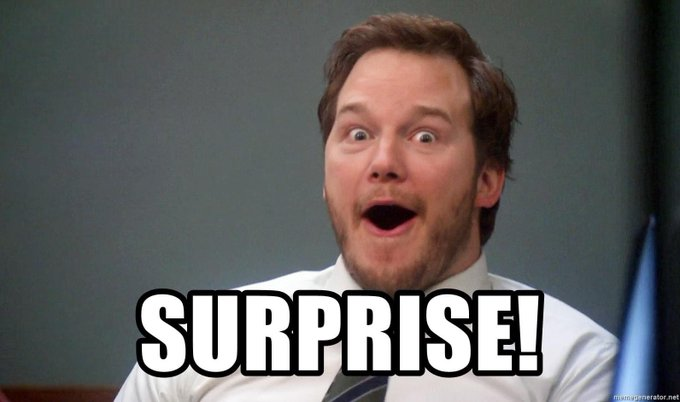

## 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [330]:
sample = pd.read_csv("data/sample_submission.csv")

In [331]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [332]:
sample.shape

(391, 2)

## 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [333]:
#¿Cómo creamos la submission?
submission = pd.DataFrame(predictions_submit, columns = [target], index = X_pred.index)

In [334]:
submission.head()

,Price_in_euros
laptop_ID,
209,1592.875340
1281,375.612101
1168,334.872851
1231,1196.283074
1020,953.183138


In [335]:
submission.shape

(391, 1)

## 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [336]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [337]:
chequeador(submission)

Check the number of rows and/or columns and try again

Mensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.


In [ ]:
submission.to_csv('submission_14.csv', index = True)

In [ ]:
df_resultado_notebook_14 = pd.read_csv("submission_14.csv")
print("RMSE del train:", root_mean_squared_error(y_test, y_pred_CA))
df_resultado_notebook_14

RMSE del train: 330.28034761177867


,laptop_ID,Price_in_euros
0,209,1592.875340
1,1281,375.612101
2,1168,334.872851
3,1231,1196.283074
4,1020,953.183138
...,...,...
386,820,2069.629264
387,948,1050.227025
388,483,1934.853712
389,1017,844.197366
